YAMNet Feature Extraction

Extract 1024-dimensional embeddings from preprocessed audio frames
using the pre-trained YAMNet model as a frozen feature extractor.

YAMNet: https://www.kaggle.com/models/google/yamnet/tfLite

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [2]:
PROCESSED_DIR = '../data/processed'
METADATA_PATH = os.path.join(PROCESSED_DIR, 'processed_frames_metadata.csv')
FEATURES_DIR = '../data/approach1/features'
YAMNET_MODEL_URL = 'https://tfhub.dev/google/yamnet/1'
TARGET_SR = 16000
BATCH_SIZE = 32
RANDOM_SEED = 42

# Create features directory
os.makedirs(FEATURES_DIR, exist_ok=True)

# Set seeds for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.15.0
GPU available: []


In [3]:
# LOAD YAMNET MODEL
print("LOADING YAMNET MODEL")
try:
    print(f"\nDownloading YAMNet from TensorFlow Hub...")
    yamnet_model = hub.load(YAMNET_MODEL_URL)
    print("YAMNet model loaded successfully")
    
    # Test the model
    test_audio = np.random.randn(15360).astype(np.float32)
    scores, embeddings, spectrogram = yamnet_model(test_audio)
    print(f"\nModel test passed:")
    print(f"  - Embedding shape: {embeddings.shape}")
    print(f"  - Embedding dimension: {embeddings.shape[1]}")
    print(f"  - Expected: (1, 1024)")
    
except Exception as e:
    print(f"Error loading YAMNet: {e}")
    raise

LOADING YAMNET MODEL




YAMNet model loaded successfully

Model test passed:
  - Embedding shape: (1, 1024)
  - Embedding dimension: 1024
  - Expected: (1, 1024)


In [4]:
# LOAD METADATA
print("LOADING DATASET")

df = pd.read_csv(METADATA_PATH)
print(f"\nLoaded metadata: {len(df)} frames")
print(f"  Categories: {df['category'].nunique()}")
print(f"  Distribution:")
for cat, count in df['category'].value_counts().sort_index().items():
    print(f"    {cat}: {count}")

LOADING DATASET

Loaded metadata: 11906 frames
  Categories: 5
  Distribution:
    Alarm_Clock: 2450
    Car_Horn: 2325
    Glass_Breaking: 2394
    Gunshot: 2355
    Siren: 2382


In [5]:
# FEATURE EXTRACTION FUNCTION
def extract_yamnet_features(audio_array):
    """
    Extract YAMNet embeddings from audio array.
    
    Args:
        audio_array: numpy array of shape (samples,) with audio at 16kHz
    
    Returns:
        embedding: numpy array of shape (1024,)
    """
    # Ensure correct dtype
    if audio_array.dtype != np.float32:
        audio_array = audio_array.astype(np.float32)
    
    # Run inference
    scores, embeddings, spectrogram = yamnet_model(audio_array)
    
    # Average embeddings across frames (usually just 1 frame for 0.96s audio)
    embedding = np.mean(embeddings.numpy(), axis=0)
    
    return embedding

In [6]:
# BATCH FEATURE EXTRACTION
print("EXTRACTING FEATURES")

features_list = []
labels_list = []
metadata_list = []
failed_files = []

print(f"\nProcessing {len(df)} audio frames...")

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    try:
        # Load audio
        audio = np.load(row['frame_path'])
        
        # Extract features
        embedding = extract_yamnet_features(audio)
        
        # Store results
        features_list.append(embedding)
        labels_list.append(row['category'])
        metadata_list.append({
            'category': row['category'],
            'original_file': row['original_file'],
            'frame_idx': row['frame_idx'],
            'aug_idx': row['aug_idx'],
            'is_augmented': row['is_augmented'],
            'frame_path': row['frame_path']
        })
        
    except Exception as e:
        failed_files.append({'file': row['frame_path'], 'error': str(e)})
        print(f"\nFailed: {os.path.basename(row['frame_path'])} - {e}")

# Convert to arrays
X = np.array(features_list)
y = np.array(labels_list)

print(f"\nFeature extraction complete:")
print(f"  - Total features extracted: {len(X)}")
print(f"  - Feature shape: {X.shape}")
print(f"  - Failed: {len(failed_files)}")

if failed_files:
    print("\nFailed files:")
    for fail in failed_files[:10]:
        print(f"  - {os.path.basename(fail['file'])}: {fail['error']}")

EXTRACTING FEATURES

Processing 11906 audio frames...


Extracting features: 100%|██████████| 11906/11906 [06:08<00:00, 32.27it/s]


Feature extraction complete:
  - Total features extracted: 11906
  - Feature shape: (11906, 1024)
  - Failed: 0


In [7]:
print("SAVING FEATURES")

# Save features and labels
features_path = os.path.join(FEATURES_DIR, 'yamnet_features.npy')
labels_path = os.path.join(FEATURES_DIR, 'yamnet_labels.npy')
metadata_df_path = os.path.join(FEATURES_DIR, 'yamnet_features_metadata.csv')

np.save(features_path, X)
np.save(labels_path, y)
pd.DataFrame(metadata_list).to_csv(metadata_df_path, index=False)

print(f"\nSaved features to:")
print(f"  - Features: {features_path}")
print(f"  - Labels: {labels_path}")
print(f"  - Metadata: {metadata_df_path}")

SAVING FEATURES

Saved features to:
  - Features: ../data/approach1/features\yamnet_features.npy
  - Labels: ../data/approach1/features\yamnet_labels.npy
  - Metadata: ../data/approach1/features\yamnet_features_metadata.csv


In [8]:
# FEATURE STATISTICS

print(f"\nFeature matrix shape: {X.shape}")
print(f"Feature dimension: {X.shape[1]}")
print(f"\nStatistics:")
print(f"  Mean: {X.mean():.6f}")
print(f"  Std: {X.std():.6f}")
print(f"  Min: {X.min():.6f}")
print(f"  Max: {X.max():.6f}")

# Check for NaN or Inf
nan_count = np.isnan(X).sum()
inf_count = np.isinf(X).sum()
print(f"\n  NaN values: {nan_count}")
print(f"  Inf values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print("Warning: Invalid values detected!")
else:
    print("No invalid values")

# Per-class statistics
print("\n" + "-"*70)
print("Per-Class Feature Statistics:")
print("-"*70)
for category in sorted(np.unique(y)):
    cat_features = X[y == category]
    print(f"\n{category}:")
    print(f"  Samples: {len(cat_features)}")
    print(f"  Mean: {cat_features.mean():.6f}")
    print(f"  Std: {cat_features.std():.6f}")
    print(f"  Range: [{cat_features.min():.6f}, {cat_features.max():.6f}]")


Feature matrix shape: (11906, 1024)
Feature dimension: 1024

Statistics:
  Mean: 0.069432
  Std: 0.350117
  Min: 0.000000
  Max: 12.673225

  NaN values: 0
  Inf values: 0
No invalid values

----------------------------------------------------------------------
Per-Class Feature Statistics:
----------------------------------------------------------------------

Alarm_Clock:
  Samples: 2450
  Mean: 0.072444
  Std: 0.384607
  Range: [0.000000, 9.663835]

Car_Horn:
  Samples: 2325
  Mean: 0.075341
  Std: 0.349127
  Range: [0.000000, 10.893569]

Glass_Breaking:
  Samples: 2394
  Mean: 0.055367
  Std: 0.335902
  Range: [0.000000, 12.673225]

Gunshot:
  Samples: 2355
  Mean: 0.063035
  Std: 0.325235
  Range: [0.000000, 10.192322]

Siren:
  Samples: 2382
  Mean: 0.081028
  Std: 0.350986
  Range: [0.000000, 7.713055]


DIMENSIONALITY REDUCTION - PCA

Computing PCA (1024 → 2 dimensions)...
PCA complete
  Explained variance ratio: [0.16262327 0.12676808]
  Total variance explained: 0.2894


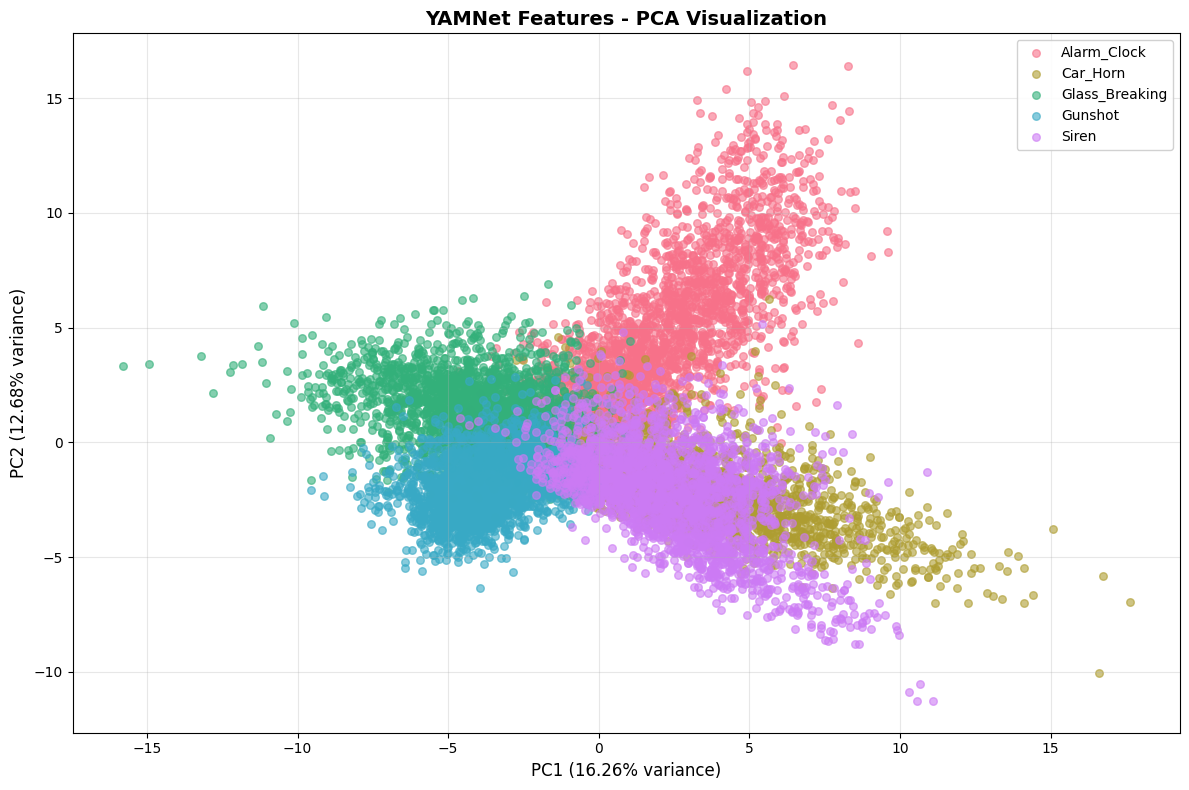

In [9]:
# FEATURE VISUALIZATION - PCA
print("DIMENSIONALITY REDUCTION - PCA")

print("\nComputing PCA (1024 → 2 dimensions)...")
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)

print(f"PCA complete")
print(f"  Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"  Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Plot PCA
plt.figure(figsize=(12, 8))
categories = sorted(np.unique(y))
colors = sns.color_palette("husl", len(categories))

for idx, category in enumerate(categories):
    mask = y == category
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[idx]], label=category, alpha=0.6, s=30)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('YAMNet Features - PCA Visualization', fontsize=14, fontweight='bold')
plt.legend(loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

DIMENSIONALITY REDUCTION - t-SNE

Computing t-SNE on 5000 samples...
t-SNE complete


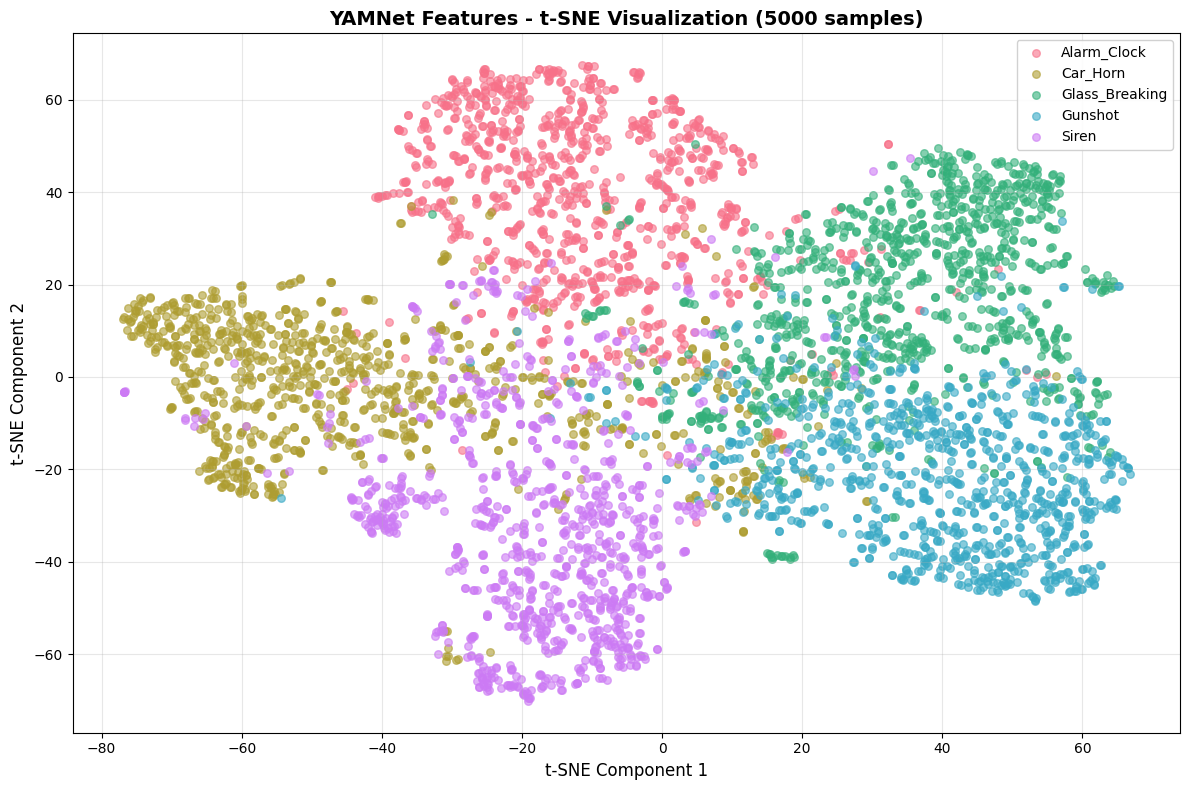

In [10]:
print("DIMENSIONALITY REDUCTION - t-SNE")

subset_size = min(5000, len(X))
indices = np.random.choice(len(X), subset_size, replace=False)
X_subset = X[indices]
y_subset = y[indices]

print(f"\nComputing t-SNE on {subset_size} samples...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, 
            perplexity=30, n_iter=1000, verbose=0)
X_tsne = tsne.fit_transform(X_subset)
print("t-SNE complete")

# Plot t-SNE
plt.figure(figsize=(12, 8))
for idx, category in enumerate(categories):
    mask = y_subset == category
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
               c=[colors[idx]], label=category, alpha=0.6, s=30)

plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title(f'YAMNet Features - t-SNE Visualization ({subset_size} samples)', 
         fontsize=14, fontweight='bold')
plt.legend(loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Feature variability:
  Total features: 1024
  Non-constant features: 732
  Constant/near-constant features: 292


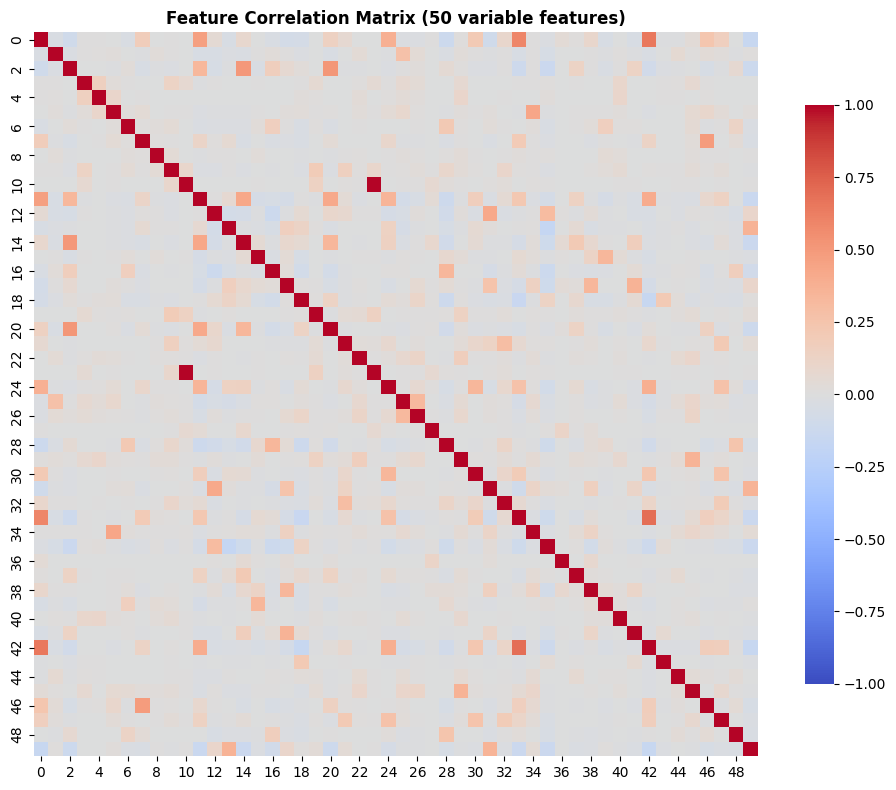


Correlation statistics:
  Mean correlation: 0.0182
  Max correlation: 0.9977
  Min correlation: -0.1664
  Std correlation: 0.0845

⚠ 1 feature pairs with |correlation| > 0.9


In [11]:
# FEATURE CORRELATION ANALYSIS

# identify non-constant features across all data
feature_stds = X.std(axis=0)
non_constant_features = np.where(feature_stds > 1e-6)[0]

print(f"\nFeature variability:")
print(f"  Total features: {X.shape[1]}")
print(f"  Non-constant features: {len(non_constant_features)}")
print(f"  Constant/near-constant features: {X.shape[1] - len(non_constant_features)}")

if len(non_constant_features) < 10:
    print("\n⚠ Warning: Too few variable features for correlation analysis")
else:
    # Sample from non-constant features only
    n_features_to_plot = min(50, len(non_constant_features))
    if len(non_constant_features) > n_features_to_plot:
        random_features = np.random.choice(non_constant_features, n_features_to_plot, replace=False)
    else:
        random_features = non_constant_features
    
    X_sample = X[:, random_features]
    
    # Compute correlation matrix
    corr_matrix = np.corrcoef(X_sample.T)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, 
                linewidths=0, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Matrix ({len(random_features)} variable features)', 
              fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Correlation statistics (excluding diagonal)
    if corr_matrix.shape[0] > 1:
        upper_triangle = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
        if len(upper_triangle) > 0:
            print(f"\nCorrelation statistics:")
            print(f"  Mean correlation: {np.mean(upper_triangle):.4f}")
            print(f"  Max correlation: {np.max(upper_triangle):.4f}")
            print(f"  Min correlation: {np.min(upper_triangle):.4f}")
            print(f"  Std correlation: {np.std(upper_triangle):.4f}")
            
            # Check for highly correlated features
            high_corr = np.sum(np.abs(upper_triangle) > 0.9)
            if high_corr > 0:
                print(f"\n⚠ {high_corr} feature pairs with |correlation| > 0.9")
        else:
            print("\n⚠ Not enough feature pairs for correlation statistics")
    else:
        print("\n⚠ Only one variable feature, skipping correlation statistics")


In [12]:
# FINAL SUMMARY
print(f"\nSuccessfully extracted features for {len(X)} samples")
print(f"Feature dimension: {X.shape[1]}")
print(f"Classes: {len(categories)}")
print(f"Files saved to: {FEATURES_DIR}")


Successfully extracted features for 11906 samples
Feature dimension: 1024
Classes: 5
Files saved to: ../data/approach1/features
